# Approximate single value decomposition

The aproximate implementation works by:
* binned the movie in 1 s bins (per channel)
* Estimating U from the binned movie.
* Iterating over the raw data to estimate S.VT 

Details in wfield-tools/decomposition.py 

The first example subtracts the average from each frame (i.e. the array in `frames_average` with 3 dimensions (ch,w,h)). The average can be the mean of all frames or only those in the baseline period of the experiment.


In [1]:
from wfield import *

# load data
localdisk = '/mnt/dual/temp_folder/CSP23_20200226/'
dat_path = glob(pjoin(localdisk,'*.dat'))[0]

dat = mmap_dat(dat_path)

# frames_average is subtracted from the raw data during decomposition.
frames_average = np.load(pjoin(localdisk,'frames_average.npy')) # or see below (can also be computed using the baseline)
# chunkidx = chunk_indices(len(dat),chunksize=64)
# frame_averages = []
# for on,off in tqdm(chunkidx):
#    frame_averages.append(dat[on:off].mean(axis=0))
#
# frames_average = np.stack(frame_averages).mean(axis = 0)

U,SVT = approximate_svd(dat, frames_average)
np.save(pjoin(localdisk,'U.npy'),U)
np.save(pjoin(localdisk,'SVT.npy'),SVT)

Computing SVT from the raw data: 100%|██████████| 84/84 [07:31<00:00,  5.37s/it]


In [ ]:
# Reconstruct and reshape into 2 channels
onset = 1000
nframes = 500
mov = reconstruct(U,SVT[:,onset*2:onset*2+nframes*2]
                 ).reshape(nframes,2,*U.shape[:2])
# take a look at the differerce between the raw and the reconstructed
napari_show((mov*frames_average)+frames_average - dat[onset:onset+nframes])

In [5]:
# Explore the reconstructed dataset
napari_show(mov)

<Figure size 432x288 with 0 Axes>

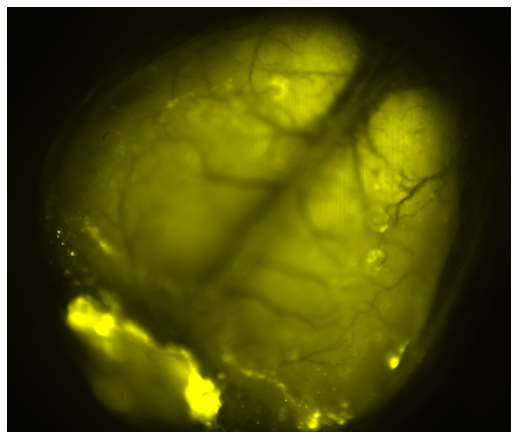

<Figure size 432x288 with 0 Axes>

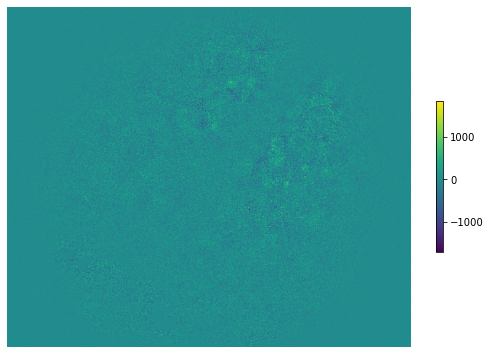

In [6]:
# Compare single frames
%matplotlib inline
# green is raw; red is reconstructed
check = np.stack([((mov[0]*frames_average)+frames_average)[0],dat[onset,0]])
plt.figure();
imshow_noborder(two_chan_to_rgb(check));
plt.figure();
imshow_noborder(np.diff(check,axis=0).squeeze());
plt.colorbar(shrink = 0.3);

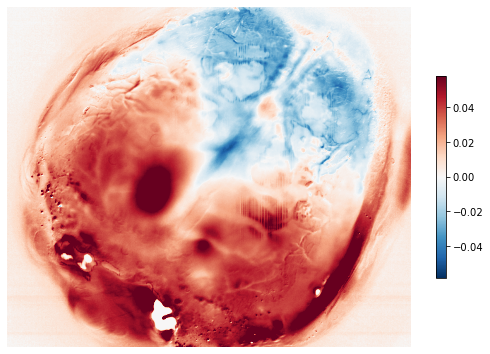

In [21]:
im = reconstruct(U,SVT[:,13000],dims = dat.shape[-2:]).squeeze()
imshow_noborder(im,
                cmap = 'RdBu_r',clim=np.array([-1,1])*np.abs(im).max()*.3);
plt.colorbar(shrink = .4);

In [10]:
np.abs(im).max()*.8

0.3363309

### Here's how to run the SVD but removing the baseline at each trial independently

To use baseline of each trial you can use the frames_average_trials intead of frames_average. 
For that data needs to be loaded per trial which is slower and you need to be careful when comparing between trials since the baseline for each trial may be different. 

This can be useful when there are slow fluctuations in the dataset.


In [ ]:
from wfield import *

localdisk = 'd:\\temp_folder'
dat_path = glob(pjoin(localdisk,'*.dat'))[0]
trial_onsets = np.load(pjoin(localdisk,'trial_onsets.npy'))

dat = mmap_dat(dat_path) # load to memory if you have enough
onsets = trial_onsets[:,1]

nbaseline_frames = 30
frames_average_trials = frames_average_for_trials(dat,
                                                  onsets,
                                                  nbaseline_frames)

U,SVT = approximate_svd(dat, frames_average_trials,onsets = onsets)
np.save(pjoin(localdisk,'Ua.npy'),U)
np.save(pjoin(localdisk,'SVTa.npy'),SVT)

In [ ]:
# this is to load the data for a specific trial

onsets = np.load(pjoin(localdisk,'trial_onsets.npy'))[:,1]
# Look at the difference between the reconstructed and the raw data
itrial = 400 # select a trial, but this can be done for any frame
ii = (onsets[itrial],onsets[itrial+1])
nframes = ii[1]-ii[0]
# Reconstruct and reshape into 2 channels
mov = reconstruct(U,SVT[:,ii[0]*2:ii[0]*2+nframes*2],
                  dims = dat.shape[-2:]).reshape(nframes,2,*dat.shape[-2:])
# This is the same as just using the frames_average unless frames_average is ntrials X nchannels X Wpix X Hpix
avg =  get_trial_baseline(ii[0],frames_average,onsets)

# take a look at the differerce between the raw and the reconstructed
napari_show((mov*avg)+avg - dat[ii[0]:ii[1]])